# LSTM Model for Predicting Myers Briggs Personality Types
### By Arnav Bhakta$^{1}$ and William Yue$^{1}$
#### $^{1}$ Phillips Academy Andover

##### The authors would like to thank Patrick Chen, Michael Huang, and Ali Cy for their helpful input and advice in crafting this notebook.

In the current notebook, we begin laying the seeds for an LSTM model that will be used to predict Myers Briggs Type Indicators (MBTIs) from an inputted text. As a precursor to this notebook and an introduction to MBTIs and the dataset that we utilize in the current study, please see my [previous notebook](https://github.com/bharnav/CSC630-Machine-Learning/blob/main/Predicting%20Myers%20Briggs%20Types/models/myers-briggs-data_0-lstm.ipynb) on the data pre-processing steps we took, to ensure that the data is optimized for the model it is being passed into.

As the purpose of this notebook is to begin to expirement with different models to see which ones provide the most accurate predictions, before settling on a particular framework and constructing a more complex architecture. We start with LSTM, because Hernandez and Knight had previously compared SimpleRNNs, GRUs, and LSTMs, to see which of the specified models performed most optimally when predicting MBTIs [[1]](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/reports/6839354.pdf). In specific, for the specific subtype of personality types that we are beginning our MBTI predictions with (Introversion and Extroversion) their LSTM achieved a 54.0% accuracy in classification [[1]](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/reports/6839354.pdf). Though these results themselves are very subpar, as LSTMs outperformed all other models tested, we would rather favor it, over the other tested models. Moreover, in comparing LSTMs ability to properly classify short texts (IMBD reviews, Douban comments, PTT posts, etc.), as is done in the current study, Wang et al. found that LSTMs consistently outperformed Naïve Bayes (NB) and Extreme Learning Machines (ELMs) [[2]](https://aclanthology.org/O18-1021.pdf). Hence, we will begin by using LSTMs in our classification task, due to their accuracy in previous studies.

### Importing Libraries

We import the below libraries to help us with building our LSTM model. Pandas is primarily used for loading in the data from a csv, and creating DataFrames. NumPy is primarily used for creating arrays and simple arithmetic. Regular expression operations (re) are primarily used for splitting up the samples and removing unwanted or implicative text from the dataset. Tensorflow is primarily used to access and utilize different machine learning (ML) architechtures. Tokenize and Tokenizer are primarily used to split up sentences into smaller units or words called tokens, to helping to understand the text and build the model, by making it easier to understand the meaning of the text, by analyzing it as a sequence of words. Matplotlib.pyplot is used for plotting the data. The remaining libraries are used for importing and exporting data.

In [3]:
import pandas as pd
import numpy as np
import re
import tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import matplotlib.pyplot as plt

### Data Pre-Processing

The following cells for the most part are a repeat of the data pre-processing steps we took, that I outlined in my [previous notebook](https://github.com/bharnav/CSC630-Machine-Learning/blob/main/Predicting%20Myers%20Briggs%20Types/models/myers-briggs-data_0-lstm.ipynb). Hence, for more information on the pre-processing steps we took, kindly refer to that notebook, as here, I will only be including details of steps that were not taken in our data pre-processing notebook.

In [4]:
df = pd.read_csv('../datasets/0.csv')
df_text = np.array(df['text'])
df_label = np.array(df['label'])

In [6]:
df_user = []
personality_types = ['intj', 'intp', 'entp', 'entj', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

In [7]:
for i in df_text:
  text = i.lower()
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'https\S+', '', text)
  text = re.sub(r'@[A-Za-z0-9]+','', text)
  for j in personality_types:
    text = re.sub(j, '', text)
  while True:
    before_text = text
    text=text.replace('  ', ' ')
    if before_text == text:
      break
  df_user.append(np.array(text.split('|||')))

In [8]:
df_user = np.array(df_user)

/var/folders/6m/2wgdj6_s0rbd4wl3f0gy7kkh0000gq/T/ipykernel_90403/856064120.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_user = np.array(df_user)


In addition to reducing the dimensionality of the text samples by flattening it to a 1-dimensional array, as we did in the [previous data pre-processing notebook](https://github.com/bharnav/CSC630-Machine-Learning/blob/main/Predicting%20Myers%20Briggs%20Types/models/myers-briggs-data_0-lstm.ipynb), we also flatten the labels for each corresponding text sample, such that in the flattened array of text, each sample has a corresponding label (0 for Extroversion, 1 for Introversion). By doing so, in training our model, we will be able to provide it with text samples, as well as the corresponding labels for these samples, so that it can start to learn patterns in the text and analyze which particular attributes result in specific MBTIs.

In [9]:
df_user_flattened = []
df_label_flattened = []

In [10]:
for index, i in enumerate(df_user):
  for j in i:
    df_user_flattened.append(j)
    df_label_flattened.append(df_label[index])

In [11]:
df_user_flattened = np.array(df_user_flattened)

### Exploring the Data Distributions

Seeing as we have two specific features, it is important to understand more about their distributions by creating histograms, so that we can learn more about the features themselves. For the labels feature, we will primarily be looking at the split between samples labeled for Extroversion versus samples labeled for Introversion, allowing us to understand which is more prevalent in the current dataset. For the text feature, stored in the `NumPy` array `df_user_flattened`, we will be looking at the distribution of the lengths of each of the samples, in order to understand how much each sample will be padded on average, when padded or truncated to 150 words.

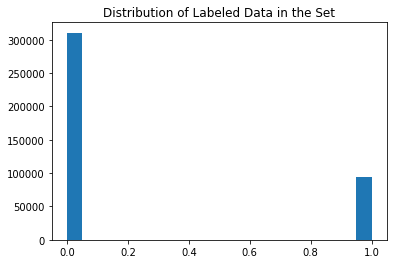

In [13]:
_ = plt.hist(df_label_flattened, bins='auto')
plt.title("Distribution of Labeled Data in the Set")
plt.show()

As can be seen from the above histogram, the large majority of labels in the dataset are for Extroversion (0) as opposed to Introversion (1) (roughly a 3 to 1 split). Though it is hard to decieve why this may be, a guess as to why, may be that as the text samples were taken from an online forum, where people are more inclined to be conversational, the majority of samples may have consequently exuded extroversive qualities. In discussing the implications of such an uneven split in the dataset, it could be argued that the set does not provide the model with enough introversive samples to truly be able to pick up on what characteristics of the text make in introversive in nature. However, it is also important to note that there are roughly 100k samples for texts labeled as being introversive, which should theoretically be enough for our model to learn what makes a text introvesive. Hence, we shall not alter the distributions of labels in the dataset.

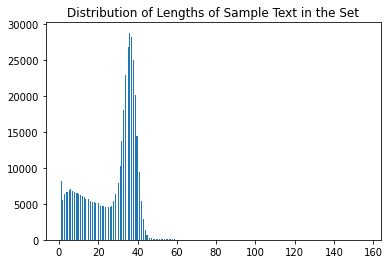

In [14]:
lens = []
for i in df_user_flattened:
  sample_lens = i.split(" ")
  lens.append(len(sample_lens))

_ = plt.hist(lens, bins='auto')
plt.title("Distribution of Lengths of Sample Text in the Set")
plt.show()

In observing the the distribution of the lengths of samples in the dataset, it can be seen that roughly 7.5% have a length close to 38 words. Given that the average tweet is roughly 55 words in length, we can assume that the majority of texts are very short in length and that when padded to a length of 150 words, the sequences will constist largely of 0s. Additionally, in looking at the distribution itself, we can see that it follows a roughly normal distribution, which reminds me of the Central Limit Theorem, and the fact that as we have more samples, as is the case in the current study, the distribution will be more likely to approach an average or most common frequency.

### Training, Validation, and Test Splits

To train and properly test the accuracy of our model, by defining a training set, validation set, and test set. The training set is the set which used to fit the model and that the model uses to learn patterns in the text of specific categories. Consequently, the training set, consists of both the text samples and its corresponding labels, such that the model can learn how to properly classify texts. The validation set serves a sort a sort of test set, which we will see soon, to test the accuracy of the model while training on a subset of the data. The test set is usde to test how well the model performs when predicting the labels of text, by providing a set of text samples as inputs, having the model predict the corresponding labels of each sample, and comparing it to the actual labels, which were not provided for testing, but were rather kept to compare how well the predicted labels matched the actual labels.

We go about splitting up our training, validation, and test sets by attributing 60% of the dataset to the training set, 20% to the validation set, and 20% to the test set (this is done by taking horizontal slices of the dataset). This is done by combining the `df_user_flattened` array of text samples and the `df_label_flattened` array of the corresponding lables, into a single array, `ds`, where column 1 is the actual text samples, and column 2 is the labels that correspond to each of the respective labels. `ds` is then shuffled using `np.random.shuffle` to ensure that there is no specific pattern that the samples in dataset are distributed via, and that they are instead in a random order.

As can be seen from `ds_train`, such a process results in the creation of an array that consists of several arrays nested inside of it, which can be observed as containing the sample text in one column, and the label for this text in the other.

In [132]:
seed = 23
np.random.seed = seed
ds_df = pd.DataFrame()
ds_df['posts']=df_user_flattened
ds_df['labels'] = df_label_flattened
ds = ds_df.to_numpy()
np.random.shuffle(ds)
front_cutoff = int(ds.shape[0]*0.6)
mid_cutoff = int(ds.shape[0]*0.8)
ds_train, ds_val, ds_test = ds[:front_cutoff], ds[front_cutoff:mid_cutoff], ds[mid_cutoff:]
ds_train


array([['if i want to enjoy life more then what other types or aspects of type should i try to develop in myself? for instance, should i somehow try to develop more s? in essence what i want is to break...',
        0],
       ["i'm not referring to my gender preference. i'm saying that no individual of any gender appeals besides him.",
        0],
       ["i've actually said these exact words once. i'm a daily smoker, which gives some people the idea that i'm lazy, lethargic, and incompetent. but actually, i'm functioning rather fine. i'm going to...",
        0],
       ...,
       ["your problem is that you're trying to emulate other types. play the cards you actually have; 's are infamously the most romantic type and it shows. i used to feel the same way, then with time i...",
        0],
       ["i just started a relationship with an girl, and i am . first of all, i love it so far. im used to and so this is a real relief. regarding affection, she's so closed off. if i...",
       

In [133]:
ds_train.shape

(243157, 2)

Next, we split the `ds_train`, `ds_val`, and `ds_test` arrays into two arrays, corresponding to text samples and labels for each array, by taking vertical slices of the data. By doing so, we are able to seperate each array into its predictors or independent variables, and the response from these predictors, or the dependent variables.

In [137]:
ds_train_texts, ds_train_labels = ds_train[:,0], ds_train[:,1]

In [138]:
ds_val_texts, ds_val_labels = ds_val[:, 0], ds_val[:, 1]

In [139]:
ds_test_texts, ds_test_labels = ds_test[:, 0], ds_test[:, 1]

### Tokenization

Once again, I went over tokenization, its importance, and its applications in my [previous data pre-processing notebook](https://github.com/bharnav/CSC630-Machine-Learning/blob/main/Predicting%20Myers%20Briggs%20Types/models/myers-briggs-data_0-lstm.ipynb). As a result, I will not be going over tokenization again, but will instead be filling in details that were not included in the pre-processing notebook. For any questions about tokenization, please refer to that notebook.

In [67]:
vocab_size = 4000 

oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size
                      ,oov_token= oov_tok
                      )
tokenizer.fit_on_texts(ds_train_texts)
word_index = tokenizer.word_index

In [68]:
word_index

After fitting our tokenizer to the training texts, we save it in a json file, `tokenizer.json`, for later use.

In [70]:
# Save tokenizer to json
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [71]:
# load in tokenizer
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [72]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'i': 2,
 'the': 3,
 'to': 4,
 'a': 5,
 'and': 6,
 'of': 7,
 'you': 8,
 'that': 9,
 'it': 10,
 'is': 11,
 'in': 12,
 'my': 13,
 'but': 14,
 'for': 15,
 'have': 16,
 'with': 17,
 'me': 18,
 'this': 19,
 "i'm": 20,
 'be': 21,
 'not': 22,
 'are': 23,
 'like': 24,
 'on': 25,
 'an': 26,
 'as': 27,
 'so': 28,
 'was': 29,
 'if': 30,
 'just': 31,
 'or': 32,
 'do': 33,
 'what': 34,
 'about': 35,
 'think': 36,
 "don't": 37,
 'people': 38,
 'when': 39,
 'your': 40,
 "it's": 41,
 'at': 42,
 'all': 43,
 'can': 44,
 'know': 45,
 'one': 46,
 'they': 47,
 'really': 48,
 'more': 49,
 'would': 50,
 'we': 51,
 'how': 52,
 'out': 53,
 'because': 54,
 'get': 55,
 'am': 56,
 'from': 57,
 "i've": 58,
 'some': 59,
 'time': 60,
 'he': 61,
 'up': 62,
 'very': 63,
 'there': 64,
 'no': 65,
 's': 66,
 'them': 67,
 'who': 68,
 'feel': 69,
 'much': 70,
 'well': 71,
 'being': 72,
 'too': 73,
 'been': 74,
 'by': 75,
 'love': 76,
 'good': 77,
 'things': 78,
 'say': 79,
 'other': 80,
 'want': 81,
 'way': 82

Much like in the [previous data pre-processing notebook](https://github.com/bharnav/CSC630-Machine-Learning/blob/main/Predicting%20Myers%20Briggs%20Types/models/myers-briggs-data_0-lstm.ipynb), we create sequences of integers, for each of the `tokenized_train`,  `tokenized_val`, and `tokenized_test` arrays, to make the texts interpretable for our model. Once again, if you have any questions about `text_to_sequences`, please refer to the linked notebook.

In [73]:
tokenized_train = tokenizer.texts_to_sequences(ds_train_texts)

In [75]:
tokenized_val = tokenizer.texts_to_sequences(ds_val_texts)

In [140]:
tokenized_test = tokenizer.texts_to_sequences(ds_test_texts)

### Padding

Padding, the method we use for padding, and the reason behind the `maxlen` we set were all discussed in the [previous data notebook](https://github.com/bharnav/CSC630-Machine-Learning/blob/main/Predicting%20Myers%20Briggs%20Types/models/myers-briggs-data_0-lstm.ipynb). We carry out the same methodology in the current notebook, by padding each of the text samples in the `padded` (`padded_train`), `padded_val`, and `padding_test` sets. For any questions about padding, please refer to the linked notebook.

In [76]:
padded = pad_sequences(tokenized_train, maxlen=150, padding='post', truncating='post')

In [77]:
padded.shape

(243157, 150)

In [78]:
padded_val = pad_sequences(tokenized_val, maxlen=150, padding='post', truncating='post')

In [141]:
padded_test = pad_sequences(tokenized_test, maxlen=150, padding='post', truncating='post')

### Bidirectional LSTM Model

In the following section, we will be discussing the model utilized in this study. As we are simply testing the effectiveness of different models in classifying sample texts on their MBTIs, we do not begin by constructing an intricate and complex architecture, but instead begin with a very baseline model.

We start building out model, by defining a `Sequential` model using `Tensorflow`'s `Keras`: a stack of layers in a neural network, where each layer has one input tensor and one output tensor. The layers of the model as as follows: an embedding layer, a bidirectional LSTM, a dropout layer, a bidirectional LSTM, a dropout layer, a dense layer, a dropout layer, and a final dense layer, as outlined in the model summary.

#### Embedding Layers

Embedding layers are utilized in neural networks to handle word embedding, or a process by which words are represented via vectors. As opposed to more traditional bag-of-word encoding, which produce very sparce vectors, embedding provides very dense vectors, where each vector represents a single word. As a result, an embedding layer is often used as the first hidden layer in neural networks, when dealing with text data [[3]](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/).

As an input, the layer requires an integer representation of the words, which we have already done via sequencing the tokenized text samples. It then requires 3 arguments, being the `input_dim`, the `output_dim`, and the `input_length`. The `input_dim` refers to the vocabulary size, or the the number of words that are represented in the sequenced data, that we defined while tokenizing the sample texts. The `output_dim` refers to the size of the vectors space that the words we pass in, will be embedded into. More generally, it sets the size of the output vector for each word. In the current study, we begin by setting the `output_dim` to 16, however, with tuning and testing, this value is subject to change. The final argument that we specify is the `input_length`, which refers to the number of words in each input sequence. During padding, we padded and truncated all samples to a length of 150 words, so this is the value we specify for this argument [[3]](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/).

#### Bidirectional LSTM

The following explanation requires a bit of familiarity with LSTMs. If you don't have that, that's okay! You can refer to my explanation of LSTMs in [this notebook](https://github.com/bharnav/CSC630-Machine-Learning/blob/main/pyData/Diabetes%20Dataset%20Investigation.ipynb) and come back here.

Bidirectional LSTMs can be viewed as a subtypes of LSTMs that have been improved for classification tasks. It does so by training two LSTMs in parallel on the input data, as opposed to the traditional one, by having one be trained on the forward input sequence and the other being trained on the backward input sequence. This is done by simply duplicating the the first layer of the LSTM in the network, such that it results in there being two layers side by side and have better access to all of the input information that is provided [[4]](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/), [[5]](https://maxwell.ict.griffith.edu.au/spl/publications/papers/ieeesp97_schuster.pdf). In doing so, it is able to split the state of the neurons, to get a more whole representation of the sample texts, as opposed to simply having a linear interpretation [[4]](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/), [[5]](https://maxwell.ict.griffith.edu.au/spl/publications/papers/ieeesp97_schuster.pdf). From a more wholistic view, this can be explained as not being able to understand a sequence of words, until you know what their future context is, emphasizing the need to have a betterunderstanding of the "end" of the sequence [[6]](https://www.sciencedirect.com/science/article/pii/S0893608005001206).

In this notebook, we utilize 2 bidirectional LSTMs as a baseline to test their effectiveness for our specific classification task. Each layer consists of 16 memory units, with the first hidden layer having a fully connected layer, that utilizes a sigmoid activation function to provide an adequate output.

#### Dropout Layer

Neural networks are often at risk of overfitting when training, which can have several adverse effects, including becoming accustomed to the noise of the training set, and consequently having low accuracy when predicting on new datasets. Dropout layers seek to prevent overfitting, by randomly ignoring a specificied number of layer outputs (in our case 10%), and allowing the layer to be viewed as a new layer, due to the differing number of nodes and changing connectivity to the input layer. As a result, each layer is seen as being different, meaning that there is a lesser amount of reliance on noise in the training set, when predicting the output vectors, and that there is the opportunity to correct any wrongdoings in previous layers. Thus, dropout layers allow us to place more trust in the fact that our model will be accurate and not overfit [[7]](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/).

Due to its relaiability, we place dropout layers in between each of the layers we use in this model.

#### Dense Layer

Dense layers are deeply connected layers in a neural network, that recieves input from the neurons of previous layers, and uses matrix-vector multiplication to transform the vectors into a single vector of a specified size. This specific value is specified via the `units` parameter. As our model consists of two dense layers, the first vector outputted has a size of 8, while the second has a size of 1. In our model, we also specify activation functions for each dense layer, via the `activation` parameter. Activation functions are often used to create a non-linear relationship in the input neuron, such that the model can learn more complex relationships between input and output vectors [[8]](https://machinelearningknowledge.ai/keras-dense-layer-explained-for-beginners/). The activation function we use for the first dense layer is a rectified linear unit  (ReLU), which is a piecewise linear function, that outputs the input directly if the input is positive, or zero otherwise. In doing so, it allows model to learn faster and perform better. A sigmoid activation function is simply a logistic function, that that transforms the input into a value between 0 and 1 [[9]](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/).

#### Learning Rate

The learning rate is a tuning paramater that specifies the step size at which weights are updated during training, while the loss function as it approaches its minimum. By doing so, it is responsible for how the model changes as a result of the estimated error it produces, each time its weights update, meaning that it is also in charge of how quickly the model adapts to the presented task. A large learning rate can cause the model to converge very quickly in the direction of an incorrect prediction, so for our model, we set a learning rate of 0.0001, so that the model spends enough time understanding trends in the input sample texts and updates accordingly [[10]](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/).

#### Loss Function

A loss function can be viewed as providing a metric for how well your model fits the training set. More specifically, as we are tasked with a binary classification problem, the loss function we utilize is binary cross-entropy:

$$H_{p}(q)=-\frac{1}{N}\sum_{i=1}^{N}y_{i}\cdot\log(p(y_{i}))+(1-y_{i})\cdot\log(1-p(y_{i}))$$

where $y$ is the label for the corresponding sample text, and $p(y)$ is the probability of the label being 1, for all of the labels in the set. More specifically, for each label of value 1, it adds the log probability of it being 1, $\log(p(y))$ to the loss, and adds the log probablity of the label being 0, $\log(1-p(y))$, for each label of value 0. In doing so it is able to provide a justified predicted probability of the classifier being right, while also penalizing the model for inaccurate predictions [[11]](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 16, input_length=150),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0001
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy', 'mse', 'mae', 'mape'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 16)           64000     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 150, 32)           4224      
_________________________________________________________________
dropout_15 (Dropout)         (None, 150, 32)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 32)                6272      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_17 (Dropout)         (None, 8)                

After creating the model, we then train the model, by fitting it to the padded training texts and its corresponding labels. I train the model on 5 epochs – nowhere near to final number of epochs I would train the model on, due to the low learning rate – in order to get a general understanding of how well the bidirectional LSTM performs when predicting the MBTI types. Training for the model took roughly 6-7 hours.

In [83]:
model.fit(x=padded, y=np.asarray(ds_train_labels).astype('float32'), batch_size=8, epochs=5, validation_data=(padded_val, np.asarray(ds_val_labels).astype('float32')))

Epoch 1/5
30395/30395 [==============================] - 3368s 111ms/step - loss: 0.5511 - accuracy: 0.7669 - mse: 0.1823 - mae: 0.3662 - mape: 192000984.7780 - val_loss: 0.5412 - val_accuracy: 0.7657 - val_mse: 0.1781 - val_mae: 0.3399 - val_mape: 156226560.0000
Epoch 2/5
30395/30395 [==============================] - 5146s 169ms/step - loss: 0.5379 - accuracy: 0.7659 - mse: 0.1771 - mae: 0.3556 - mape: 181249941.0486 - val_loss: 0.5371 - val_accuracy: 0.7657 - val_mse: 0.1767 - val_mae: 0.3547 - val_mape: 178648384.0000
Epoch 3/5
30395/30395 [==============================] - 2724s 90ms/step - loss: 0.5305 - accuracy: 0.7684 - mse: 0.1741 - mae: 0.3500 - mape: 178211269.8192 - val_loss: 0.5384 - val_accuracy: 0.7657 - val_mse: 0.1772 - val_mae: 0.3614 - val_mape: 189144192.0000
Epoch 4/5
30395/30395 [==============================] - 4595s 151ms/step - loss: 0.5303 - accuracy: 0.7655 - mse: 0.1743 - mae: 0.3501 - mape: 177314560.3795 - val_loss: 0.5392 - val_accuracy: 0.7657 - val_ms

### Results

The final step we take, is seeing how well the model performs when predicting on the testing set. We do this by using the `model.predict` function, and having it predicting on the padding sample texts, and comparing it to the actual labels for the corresponding texts. We can then compute metrics for the accuracy of the predictions, using the `model.evaluate` function.

In doing so, we see that in comparison to Hernandez and Knight's model, which recieved an accuracy of 54.0%, our baseline model greatly outperforms theirs with an accuracy of 76.504%. Though this result may seem to be very good compared to those of previous studies, something that seems off, is the fact that in our dataset we know that roughly 25% of the sample texts have a label of 1, while the remaining ~75% have a label of 0. This raises some suspicions due to the fact that we achieved a nearly 75% accuracy, which might implicate that our model might not be as accurate as we had initially assumed, and that it is just predicting 0s.

In [143]:
predictions = model.predict(padded_test)

In [145]:
print(np.mean(predictions))

0.22614066


In [153]:
labels_test = np.asarray(ds_test_labels).astype('float32')

In [154]:
model.evaluate(predictions, labels_test)

2533/2533 [==============================] - 7s 2ms/step - loss: 0.5626 - accuracy: 0.7651 - mse: 0.1869 - mae: 0.4043 - mape: 244507056.0000


[0.5625528693199158,
 0.7651042938232422,
 0.18689122796058655,
 0.40433382987976074,
 244507056.0]

In [174]:
# check number of correct predictions
count = 0.0
correct = 0.0
for i in range(len(predictions)):
    predict = 0
    if predictions[i] < 0.5:
        predict = 0
    else:
        predict = 1
    if predict == labels_test[i]:
        correct += 1.0
    
    count += 1.0

print('test accuracy: ' + str(correct/count*100) +'%')

test accuracy: 76.50426264296202%


To test this hypothesis, we look at how many predictions the model actually outputted were 1s, and of these, how many were correct. As the model doesn't necessarily output integer label predictions 1 and 0, we take all predicted labels $\geq 0.5$ to be a predicted label of 1, and predicted labels $< 0.5$ to be a predicted label of 0. In this manner, we discover that the model only outputted 125 positive label predictions, in comparison to the nearly 8000 predictions it made, of which only 60 of these predictions were correct. Accordingly, it is safe to say that the accuracy of our model was based on a false premise, and that more fine tuning to the model is necessary.

In [172]:
num_pos = 0
index_pos = []
index_correct_pos = []
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        num_pos += 1
        index_pos.append(i)
        if labels_test[i] == 1.0:
            index_correct_pos.append(i)
            
print('number of positive predictions: ' + str(num_pos))
print('\nindices of positive predictions:')
print(index_pos)
print('\nindices of correct positive predictions:')
print(index_correct_pos)

number of positive predictions: 125

indices of positive predictions:
[524, 698, 986, 1367, 2766, 3834, 5183, 5817, 5920, 7801, 7957, 9722, 10273, 10472, 12069, 14150, 15378, 16681, 17795, 17797, 17868, 18603, 19804, 20534, 20835, 21738, 21767, 22083, 22650, 22819, 22965, 23655, 25123, 28069, 28670, 28731, 29747, 30038, 31044, 31954, 32388, 32669, 33716, 33966, 33976, 36077, 36294, 36935, 37216, 38093, 38231, 38922, 39228, 39645, 39902, 40392, 41708, 41935, 43202, 45416, 46262, 47024, 47206, 47322, 47798, 48050, 49093, 49362, 49583, 50414, 50517, 51056, 51280, 51866, 52005, 52233, 53121, 54471, 54909, 55677, 56169, 56598, 57158, 57345, 57727, 58106, 58385, 58782, 59439, 59661, 59838, 59986, 60124, 60479, 61242, 61372, 62517, 63030, 64617, 65396, 66385, 66551, 66896, 68632, 69251, 69961, 70813, 71743, 72373, 72896, 73658, 73665, 74598, 74652, 74836, 75253, 77236, 78181, 78841, 78908, 78925, 79375, 79446, 80285, 80304]

indices of correct positive predictions:
[524, 986, 2766, 3834, 5817

Looking more in-depth at the distribution of the predicted label values via a histogram, we see nearly all of the predictions are $< 0.5$. In fact, the majority of the predicred labels recieved values $< 0.3$, indicating that the model had a tendency to predict high values of 0 labels.

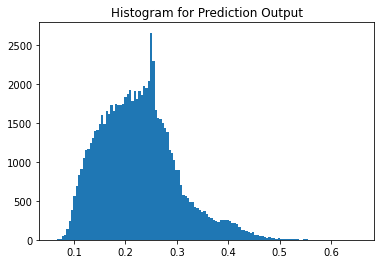

In [178]:
_ = plt.hist(predictions, bins='auto')
plt.title("Histogram for Prediction Output")
plt.show()

In seeing these results, it is clear a more complex architecture is required to handle this classificaton task. Moreover, it suggests that bidirectional LSTMs may not be the best approach for handing this problem. Instead, we plan on testing the effectiveness of convolutional neural networks (CNNs), which have historically been know to perform optimally for classification tasks. We are considering the possibility of taking a combined approach using eXtreme gradient boosting (XGBoost) and CNNs, to pretrain the data via a decision tree-based method, before passing the outputs as inputs to a model consistent of CNNs. A final model we may consider in the future, is the use of transformers, due to their prevalence in handling textually based data.